# Packages

In [74]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt 
from glob import glob
import os

sns.set(style='darkgrid')
%matplotlib inline

In [75]:
import tensorflow as tf
import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D ,Input, Lambda, UpSampling2D
from tensorflow.keras.optimizers import Adam , RMSprop , Adagrad , Adamax , SGD

# Import the Dataset

In [49]:
IMM_SIZE = 64

In [50]:
def get_data(folder):
    class_names = [f for f in os.listdir(folder) if not f.startswith('.')] # ctreate a list of SubFolders

    data = []
    print(class_names)
    for t, f in enumerate(class_names):
        images = glob(folder + "/" + f + "/*") # create a list of files
        print("Downloading: ", f)
        fig = plt.figure(figsize = (50,50)) 
        for im_n, im in enumerate(images):
            plt.gray() # set grey colormap of images
            image = cv2.imread(im)
            if len(image.shape) > 2:
                #image = cv2.resize(image, [IMM_SIZE, IMM_SIZE, image.shape[2]]) # resize of RGB and png images
                image = cv2.resize(image, (IMM_SIZE, IMM_SIZE), interpolation = cv2.INTER_LINEAR) # resize of RGB and png images
            else:
                #image = cv2.resize(image, [IMM_SIZE, IMM_SIZE]) # resize of grey images
                image = cv2.resize(image, (IMM_SIZE, IMM_SIZE))
            if len(image.shape) > 2:
                #image = cv2.cvtColor.rgb2grey(image[:,:,:3])  # change of colormap of images alpha chanel delete
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image.flatten()
                                           
            data.append([image, f])
        

    return np.array(data) 

In [51]:
dir_data='c:/wbc/train'
data = get_data(dir_data)

['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']
Downloading:  Basophil
Downloading:  Eosinophil
Downloading:  Lymphocyte
Downloading:  Monocyte
Downloading:  Neutrophil


C:\Users\Ahmad\AppData\Local\Temp\ipykernel_5416\1737551885.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

In [52]:
print("data shape", data.shape) # Size of the training DataSet
print("Image size", data[0][0].shape) # Size of image

data shape (10175, 2)
Image size (64, 64)


In [53]:
images = []
labels = []

# image_test = []
# label_test = []

for feature, label in data:
    images.append(feature)
    labels.append(label)

# for feature, label in test:
#     image_test.append(feature)
#     label_test.append(label)

# Normalize the data
images = np.array(images) / 255.0
# image_test = np.array(image_test) / 255.0

# Reshaping input images
images = images.reshape(-1, IMM_SIZE, IMM_SIZE, 1)
# image_test = image_test.reshape(-1, IMM_SIZE, IMM_SIZE, 1)

# Creating a dictionary of clases
lab = {}
for i, l in enumerate(set(labels)):
    lab[l] = i


labels = np.array([lab[l] for l in labels])


In [54]:
print("Shape of the input DataSet:", images.shape)
print("Shape of the output DataSet:", labels.shape)
print("Dictionary of classes:", lab)

Shape of the input DataSet: (10175, 64, 64, 1)
Shape of the output DataSet: (10175,)
Dictionary of classes: {'Lymphocyte': 0, 'Basophil': 1, 'Eosinophil': 2, 'Monocyte': 3, 'Neutrophil': 4}


# One-hot Encoding

In [55]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils , to_categorical

In [56]:
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
dummy_Y = np_utils.to_categorical(encoded_Y)
dummy_Y.astype(int)

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

# Train Test split

In [57]:
train_image, test_image, train_label, test_label = train_test_split(images, dummy_Y, test_size = .3, random_state = 42)

In [57]:
print(f"image_train: {train_image.shape}")
print(f"label_train: {train_label.shape}")
print('-------------')
print(f"image_test: {test_image.shape}")
print(f"label_test: {test_label.shape}")

image_train: (7122, 64, 64, 1)
label_train: (7122, 5)
-------------
image_test: (3053, 64, 64, 1)
label_test: (3053, 5)


# Autoencoder

### A simple Autoencoder

In [76]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim  
    
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(4096, activation='sigmoid'),
      layers.Reshape((64, 64))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder1 = Autoencoder(latent_dim)

In [77]:
autoencoder1.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [78]:
autoencoder1.fit(train_image, train_image,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_data=(test_image, test_image))

Epoch 1/20
223/223 [==============================] - 3s 9ms/step - loss: 0.0231 - val_loss: 0.0224
Epoch 2/20
223/223 [==============================] - 2s 8ms/step - loss: 0.0212 - val_loss: 0.0204
Epoch 3/20
223/223 [==============================] - 2s 8ms/step - loss: 0.0192 - val_loss: 0.0188
Epoch 4/20
223/223 [==============================] - 2s 8ms/step - loss: 0.0184 - val_loss: 0.0184
Epoch 5/20
223/223 [==============================] - 2s 8ms/step - loss: 0.0181 - val_loss: 0.0183
Epoch 6/20
223/223 [==============================] - 2s 8ms/step - loss: 0.0181 - val_loss: 0.0183
Epoch 7/20
223/223 [==============================] - 2s 8ms/step - loss: 0.0181 - val_loss: 0.0184
Epoch 8/20
223/223 [==============================] - 2s 8ms/step - loss: 0.0180 - val_loss: 0.0182
Epoch 9/20
223/223 [==============================] - 2s 8ms/step - loss: 0.0180 - val_loss: 0.0184
Epoch 10/20
223/223 [==============================] - 2s 8ms/step - loss: 0.0180 - val_loss: 0.0182

In [82]:
encoded_imgs_1 = autoencoder1.encoder(test_image).numpy()
decoded_imgs_1 = autoencoder1.decoder(encoded_imgs_1).numpy()

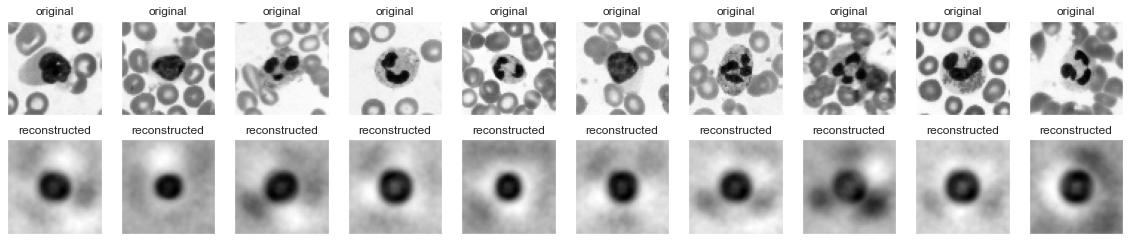

In [83]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_image[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs_1[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional Autoencoder

In [27]:
class ConvAutoencoder(Model):
  def __init__(self):
    super(ConvAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(64, 64, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder3 = ConvAutoencoder()

In [28]:
autoencoder3.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [29]:
autoencoder3.fit(train_image, train_image,
                epochs=10,
                shuffle=True,
                validation_data=(test_image, test_image))

Epoch 1/10
223/223 [==============================] - 28s 120ms/step - loss: 0.0117 - val_loss: 0.0026
Epoch 2/10
223/223 [==============================] - 25s 113ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 3/10
223/223 [==============================] - 27s 120ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/10
223/223 [==============================] - 26s 116ms/step - loss: 0.0010 - val_loss: 9.3703e-04
Epoch 5/10
223/223 [==============================] - 26s 116ms/step - loss: 8.8618e-04 - val_loss: 8.4442e-04
Epoch 6/10
223/223 [==============================] - 26s 117ms/step - loss: 8.1336e-04 - val_loss: 7.9743e-04
Epoch 7/10
223/223 [==============================] - 26s 115ms/step - loss: 7.5987e-04 - val_loss: 7.5405e-04
Epoch 8/10
223/223 [==============================] - 25s 113ms/step - loss: 7.2126e-04 - val_loss: 7.1874e-04
Epoch 9/10
223/223 [==============================] - 26s 115ms/step - loss: 6.9175e-04 - val_loss: 6.9068e-04
Epoch 10/10
223/223 [========

In [30]:
autoencoder3.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 8)         1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [31]:
autoencoder3.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 8)        584       
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 64, 64, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [32]:
encoded_imgs_3 = autoencoder3.encoder(test_image).numpy()
decoded_imgs_3 = autoencoder3.decoder(encoded_imgs_3).numpy()

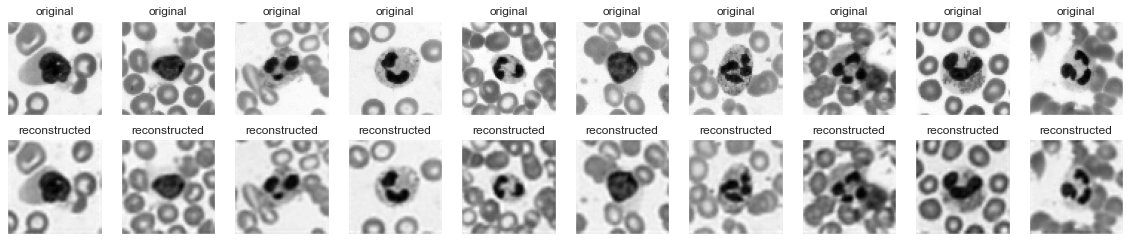

In [33]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(test_image[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs_3[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# Second Conv Autoencoder

In [132]:
batch_size = 128
epochs = 10
inChannel = 1
x, y = 64, 64
input_img = Input(shape = (x, y, inChannel))

In [141]:
def autoencoder4(input_img):
    #encoder
    #input = 64 x 64 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #64 x 64 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #32 x 32 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #16 x 16 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #16 x 16 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 32 x 32 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 64 x 64 x 1
    return decoded

In [142]:
autoencoder4 = Model(input_img, autoencoder4(input_img))
autoencoder4.compile(loss='mean_squared_error', optimizer = RMSprop())

In [143]:
autoencoder4.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 16, 16, 128)       738

### Train the model

In [61]:
autoencoder4 = autoencoder4.fit(train_image, train_image, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(test_image, test_image))

Epoch 1/10
56/56 [==============================] - 141s 3s/step - loss: 0.0216 - val_loss: 0.0133
Epoch 2/10
56/56 [==============================] - 153s 3s/step - loss: 0.0094 - val_loss: 0.0052
Epoch 3/10
56/56 [==============================] - 164s 3s/step - loss: 0.0063 - val_loss: 0.0062
Epoch 4/10
56/56 [==============================] - 156s 3s/step - loss: 0.0050 - val_loss: 0.0030
Epoch 5/10
56/56 [==============================] - 157s 3s/step - loss: 0.0040 - val_loss: 0.0034
Epoch 6/10
56/56 [==============================] - 163s 3s/step - loss: 0.0037 - val_loss: 0.0028
Epoch 7/10
56/56 [==============================] - 159s 3s/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/10
56/56 [==============================] - 160s 3s/step - loss: 0.0029 - val_loss: 0.0025
Epoch 9/10
56/56 [==============================] - 167s 3s/step - loss: 0.0028 - val_loss: 0.0016
Epoch 10/10
56/56 [==============================] - 199s 4s/step - loss: 0.0025 - val_loss: 0.0018


### Training vs Validation Loss Plot

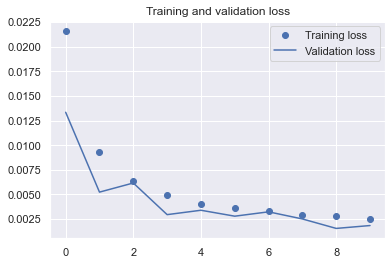

In [62]:
loss = autoencoder4.history['loss']
val_loss = autoencoder4.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Testing loss')
plt.title('Training and Testing loss')
plt.legend()
plt.show()

### Predicting on Test Data

In [64]:
pred = autoencoder4.predict(test_image)

96/96 [==============================] - 14s 148ms/step


In [65]:
pred.shape

(3053, 64, 64, 1)

Test Images


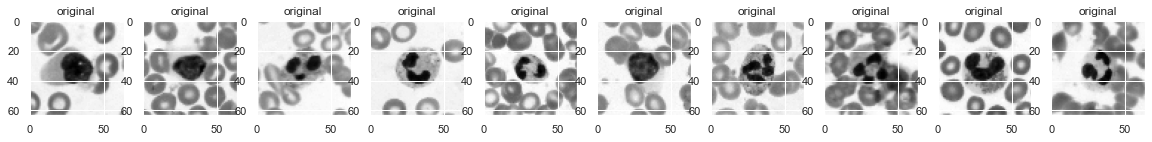

Reconstruction of Test Images


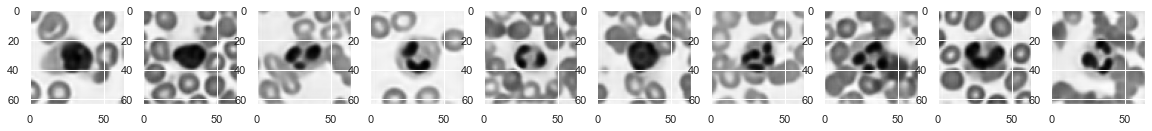

In [73]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_image[i, ..., 0], cmap='gray')
    curr_lbl = test_label[i]
    plt.title("original")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()